In [1]:
import torch
import torch.nn as nn
import torch.optim as optim
from torchvision import datasets, transforms
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np

In [2]:
# 1. Налаштування
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
batch_size = 128
epochs = 10
noise_factor = 0.5

In [3]:
# 2. Завантаження MNIST з додаванням шуму
transform = transforms.ToTensor()

train_dataset = datasets.MNIST(root='./data', train=True, download=True, transform=transform)
test_dataset = datasets.MNIST(root='./data', train=False, download=True, transform=transform)

train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
test_loader = DataLoader(test_dataset, batch_size=batch_size, shuffle=False)

100%|██████████| 9.91M/9.91M [00:01<00:00, 5.44MB/s]
100%|██████████| 28.9k/28.9k [00:00<00:00, 154kB/s]
100%|██████████| 1.65M/1.65M [00:01<00:00, 1.52MB/s]
100%|██████████| 4.54k/4.54k [00:00<00:00, 6.19MB/s]


In [4]:
# 3. Побудова автокодувальника
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True),
            nn.Linear(64, 12),
            nn.ReLU(True),
            nn.Linear(12, 3)  # Ботлнек
        )
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True),
            nn.Linear(128, 28 * 28),
            nn.Sigmoid()  # Для нормалізації [0,1]
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x

model = Autoencoder().to(device)
criterion = nn.MSELoss()
optimizer = optim.Adam(model.parameters(), lr=1e-3)

In [5]:
# 4. Функція для додавання шуму
def add_noise(img, noise_factor=noise_factor):
    noisy = img + noise_factor * torch.randn_like(img)
    noisy = torch.clip(noisy, 0., 1.)
    return noisy

In [6]:
# 5. Навчання моделі
losses = []

for epoch in range(epochs):
    running_loss = 0.0
    for data in train_loader:
        img, _ = data
        img = img.view(img.size(0), -1).to(device)
        noisy_img = add_noise(img)

        # Прямий прохід
        output = model(noisy_img)
        loss = criterion(output, img)

        # Зворотній прохід
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    epoch_loss = running_loss / len(train_loader)
    losses.append(epoch_loss)
    print(f'Epoch [{epoch+1}/{epochs}], Loss: {epoch_loss:.4f}')

Epoch [1/10], Loss: 0.0715
Epoch [2/10], Loss: 0.0582
Epoch [3/10], Loss: 0.0509
Epoch [4/10], Loss: 0.0456
Epoch [5/10], Loss: 0.0429
Epoch [6/10], Loss: 0.0415
Epoch [7/10], Loss: 0.0405
Epoch [8/10], Loss: 0.0398
Epoch [9/10], Loss: 0.0391
Epoch [10/10], Loss: 0.0386


In [7]:
# 6. Тестування моделі
model.eval()
with torch.no_grad():
    for batch in test_loader:
        img, _ = batch
        img = img.view(img.size(0), -1).to(device)
        noisy_img = add_noise(img)
        output = model(noisy_img)
        break  # Тільки перший батч для візуалізації

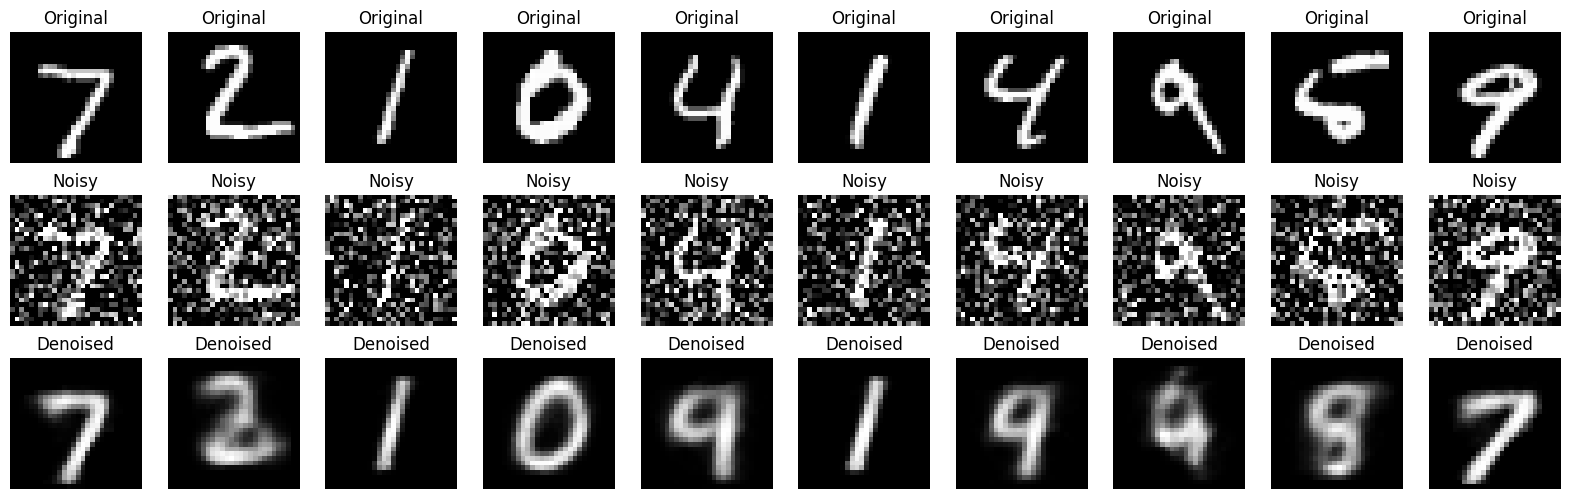

In [8]:
# 7. Візуалізація результатів
img = img.view(-1, 1, 28, 28).cpu()
noisy_img = noisy_img.view(-1, 1, 28, 28).cpu()
output = output.view(-1, 1, 28, 28).cpu()

def imshow(img, title):
    img = img.numpy().squeeze()
    plt.title(title)
    plt.imshow(img, cmap='gray')
    plt.axis('off')

n = 10
plt.figure(figsize=(20, 6))
for i in range(n):
    # Оригінал
    plt.subplot(3, n, i + 1)
    imshow(img[i], 'Original')

    # Шум
    plt.subplot(3, n, i + 1 + n)
    imshow(noisy_img[i], 'Noisy')

    # Відновлене
    plt.subplot(3, n, i + 1 + 2*n)
    imshow(output[i], 'Denoised')
plt.show()

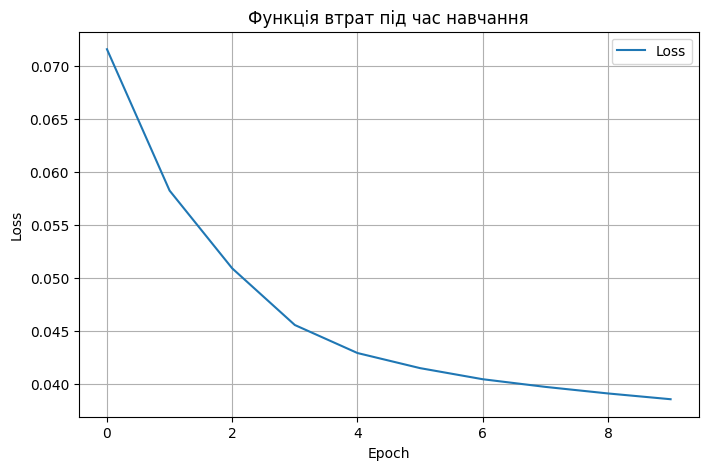

In [9]:
# 8. Графік втрат
plt.figure(figsize=(8,5))
plt.plot(losses, label='Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.title('Функція втрат під час навчання')
plt.legend()
plt.grid()
plt.show()

Висновок:
У цьому проєкті ми реалізували денойзинговий автокодувальник на базі PyTorch для очищення зображень рукописних цифр із шумом, використовуючи датасет MNIST. Модель навчалася відновлювати оригінальні зображення з їхніх зашумлених версій, що дозволило їй вивчити стійкі до шуму ознаки та структури даних.

Основні результати та спостереження:
Ефективність денойзингу: Модель успішно відновлювала зашумлені зображення, зберігаючи ключові риси цифр. Це свідчить про здатність автокодувальника вивчати суттєві характеристики даних, ігноруючи випадкові перешкоди.

Стабільне зменшення функції втрат: Графік функції втрат демонструє поступове зменшення помилки протягом епох навчання, що вказує на ефективне навчання моделі та її здатність до узагальнення.

Візуалізація результатів: Порівняння оригінальних, зашумлених та відновлених зображень показало, що модель здатна ефективно очищати зображення, відновлюючи їх до близького до оригіналу стану.

Переваги використання денойзингових автокодувальників:
Узагальнення та стійкість: Додавання шуму до вхідних даних під час навчання сприяє кращому узагальненню моделі та зменшує ризик перенавчання.

Вивчення суттєвих ознак: Модель навчається виділяти ключові характеристики даних, що робить її корисною для задач з обмеженими або зашумленими даними.

Універсальність: Автокодувальники можуть бути застосовані до різних типів даних, включаючи зображення, текст та інші, для задач зменшення розмірності, виявлення аномалій та очищення даних.

Можливі напрямки для подальшого розвитку:
Використання згорткових автокодувальників: Застосування згорткових шарів може покращити якість відновлення зображень, особливо для складніших структур.

Розширення на інші типи шуму: Дослідження ефективності моделі при різних типах шуму, таких як спекл-шум або імпульсний шум, може підвищити її універсальність.

Застосування до інших датасетів: Перевірка моделі на інших наборах даних, таких як CIFAR-10 або Fashion-MNIST, дозволить оцінити її здатність до узагальнення на різних типах зображень.

У підсумку, реалізований денойзинговий автокодувальник продемонстрував ефективність у задачі очищення зображень від шуму, що підтверджує його потенціал для широкого спектру застосувань у сфері обробки зображень та машинного навчання.